__Author:__ Bram Van de Sande

__Date:__ 5 MAR 2018

__Outline:__ Compare the results of the different implementation of the SCENIC pipeline. The example used in the tutorial is used in this comparison (https://github.com/aertslab/SCENIC).

In [1]:
import pandas as pd
import os
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
import matplotlib.pyplot as plt
from pyscenic.utils import save_to_yaml
from collections import defaultdict
from pyscenic.genesig import Regulome
from operator import concat
from functools import reduce
from pyscenic.prune import prune_targets
%matplotlib inline

In [179]:
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"
DATABASE_FNAME_500bp = os.path.join(DATABASE_FOLDER, "mm9-500bp-upstream-7species.mc8nr.feather")
DATABASE_FNAME_10kbp = os.path.join(DATABASE_FOLDER, "mm9-tss-centered-10kb-7species.mc8nr.feather")

RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v8-nr.mgi-m0.001-o0.0.tbl")

------

## Phase Ib: Derive potential regulomes from the co-expression modules

#### Check implementation of `modules_from_genie3`

Start from the GENIE3 output and check if derived co-expression modules are similar.

In [2]:
adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.5_GENIE3_linkList.txt',
                          usecols=['TF', 'Target', 'weight'])
adjacencies.columns = ["TF", "target", "importance"]

Creation of the modules.

In [3]:
df_modules = adjacencies[adjacencies['importance'] > 0.001]
df_modules['method'] = 'w001'

df_tmp = adjacencies[adjacencies['importance'] > 0.005].copy()
df_tmp['method'] = 'w005'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='TF').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(5, "importance")).copy()
df_tmp['method'] = 'top5perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(10, "importance")).copy()
df_tmp['method'] = 'top10perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50perTarget'
df_modules = df_modules.append(df_tmp)
df_modules.index = range(len(df_modules))

In [4]:
len(df_modules)

4363616

In [5]:
df_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

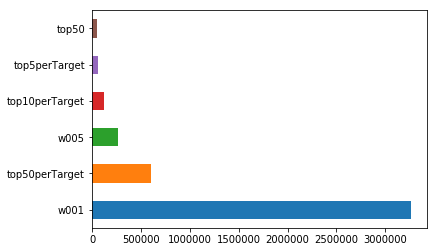

In [6]:
df_modules.method.value_counts().plot.barh()

Compare the results with the modules derived by the R pipeline.

In [ ]:
%%R
load('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.6_tfModules.RData')
write.csv(tfModules, '/Users/bramvandesande/Projects/lcb/resources/rscenic/1.6_tfModules.txt')

In [8]:
r_modules = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.6_tfModules.txt',
                          usecols=['Target', 'TF', 'method'])
r_modules.columns = ['target', 'TF', 'method']

In [9]:
len(r_modules)

4363616

In [10]:
r_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

Exact comparison.

In [11]:
COLUMN_NAMES = ['TF', 'target', 'method']
df_modules = df_modules[COLUMN_NAMES].sort_values(by=COLUMN_NAMES).reset_index()
del df_modules['index']

In [12]:
r_modules = r_modules.sort_values(by=COLUMN_NAMES).reset_index()
del r_modules['index']
r_modules = r_modules[COLUMN_NAMES]

In [13]:
r_modules.equals(df_modules)

True

--------

## Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)


### Prerequisites: are the inputs the same?

#### 1. Modules

They are the same for both pipelines because they both start from the same RData file.

_Proof:_ 

Use the same adjancencies from the tutorial.

In [ ]:
%%R
load('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.7_tfModules_withCorr.RData')
write.csv(tfModules_withCorr, '/Users/bramvandesande/Projects/lcb/resources/rscenic/1.7_tfModules_withCorr.txt')

In [36]:
r_adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.7_tfModules_withCorr.txt',
                         usecols=['Target', 'TF', 'method', 'corr'])
r_adjacencies.head()

,Target,TF,method,corr
0,Slc27a3,1810024B03Rik,w001,0
1,Ankrd39,1810024B03Rik,w001,1
2,Tbc1d25,1810024B03Rik,w001,0
3,Mak,1810024B03Rik,w001,1
4,Tmem86b,1810024B03Rik,w001,1


1. Remove genes in a module that are not part of the database rankings.
2. Remove modules with number of genes < 20.
3. Add own TF to its own module.
4. Only look at TF-target that have an activiting function.

In [37]:
genes_in_db = RankingDatabase(DATABASE_FNAME_500bp, name="500bp", nomenclature="MGI").geneset
r_adjacencies = r_adjacencies[r_adjacencies['corr'] > 0]
method2modules = defaultdict(list)
for (tf, method), df_grp in r_adjacencies.groupby(by=['TF', 'method']):
    targets = set(df_grp['Target'].values)
    if len(targets) < 20:
        continue
    targets.add(tf)
    regulome = Regulome(name="{} - {}".format(tf, method), nomenclature="MGI", 
                        score=0.0, context=frozenset([method]),
                        transcription_factor=tf, gene2weights=targets.intersection(genes_in_db))
    method2modules[method].append(regulome)

In [38]:
for method, modules in method2modules.items():
    print(method, "-", len(modules))

top50 - 974
top50perTarget - 976
w001 - 1004
w005 - 612
top10perTarget - 486
top5perTarget - 259


In [39]:
modules = reduce(concat, method2modules.values())
len(modules)

4311

In [40]:
save_to_yaml(modules, os.path.join(RESOURCES_FOLDER, "modules_zeisel_2015.yaml"))

#### 2. Databases

They are exactly the same. The 7species version of the database was used. The R-based databases are 1-based while the python versions are 0-based. The AUC calculation methods take this difference into account.

_Proof:_

Convert the RData rankings file to txt in R:

In [ ]:
%%R
install.packages("http://scenic.aertslab.org/downloads/Rpackages/RcisTarget_0.99.0.tar.gz", repos=NULL)
load('/Users/bramvandesande/Projects/lcb/databases/RcisTarget.mm9.motifDatabases.20k/data/mm9_10kbpAroundTss_motifRanking.RData')
rankings <- as.data.frame(mm9_10kbpAroundTss_motifRanking@rankings)
write.csv(rankings, '/Users/bramvandesande/Projects/lcb/resources/rscenic/mm9_10kbpAroundTss_motifRanking.txt')

This results in:
```
>>head -5 mm9_10kbpAroundTss_motifRanking.txt | cut -d',' -f1-4
"","rn","jaspar__MA1023.1","taipale__DBP_DBD_NRTTACGTAAYN"
"1","0610007C21Rik",17074,20247
"2","0610007L01Rik",2779,14344
"3","0610007P08Rik",13401,3668
"4","0610007P14Rik",9703,9810
```

In [3]:
df_rankings_r = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/mm9_10kbpAroundTss_motifRanking.txt',
                          sep=",")
del df_rankings_r['Unnamed: 0']
df_rankings_r.set_index('rn', inplace=True)
df_rankings_r = df_rankings_r.T

Load python databases.

In [27]:
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"
DATABASE_FNAME_10kbp_7sp = os.path.join(DATABASE_FOLDER, "mm9-tss-centered-10kb-7species.mc8nr.feather")
DATABASE_FNAME_10kbp_10sp = os.path.join(DATABASE_FOLDER, "mm9-tss-centered-10kb-10species.mc8nr.feather")

In [30]:
rnkdbs = [RankingDatabase(fname, name, "MGI") for fname, name in zip([DATABASE_FNAME_10kbp_7sp, DATABASE_FNAME_10kbp_10sp], ['10kbp_7sp', '10kbp_10sp'])]
df_rankings_python = rnkdbs[0].load_full()
rnkdbs

[FeatherRankingDatabase(name="10kbp_7sp",nomenclature=MGI),
 FeatherRankingDatabase(name="10kbp_10sp",nomenclature=MGI)]

Compare databases.

In [31]:
df_rankings_python.head()

,0610007C21Rik,0610007L01Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,rp9
features,,,,,,,,,,,,,,,,,,,,,
jaspar__MA1023.1,17073,2778,13400,9702,9939,17462,21205,20453,14385,16427,...,12527,16598,16211,15110,7642,18143,6576,11923,9174,16649
taipale__DBP_DBD_NRTTACGTAAYN,20246,14343,3667,9809,20880,12071,21287,18210,8132,14668,...,10315,11262,20894,11005,9941,17313,9217,18784,5116,17073
cisbp__M4240,16807,13328,9744,14328,20185,7853,20842,19961,11189,13745,...,10063,18400,20008,12029,9912,7628,15223,20636,6397,11057
scertf__macisaac.ACE2,18395,15411,8021,14640,20831,12372,18688,16341,11115,15910,...,16318,18077,20963,16080,10168,14438,9159,19352,3602,10770
transfac_pro__M06931,14964,10267,12241,15530,20887,14106,21426,21046,4870,15032,...,10989,13681,19851,11169,14565,11649,6007,17693,275,14800


In [20]:
df_rankings.head()

rn,0610007C21Rik,0610007L01Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,rp9
jaspar__MA1023.1,17074,2779,13401,9703,9940,17463,21206,20454,14386,16428,...,12528,16599,16212,15111,7643,18144,6577,11924,9175,16650
taipale__DBP_DBD_NRTTACGTAAYN,20247,14344,3668,9810,20881,12072,21288,18211,8133,14669,...,10316,11263,20895,11006,9942,17314,9218,18785,5117,17074
cisbp__M4240,16808,13329,9745,14329,20186,7854,20843,19962,11190,13746,...,10064,18401,20009,12030,9913,7629,15224,20637,6398,11058
scertf__macisaac.ACE2,18396,15412,8022,14641,20832,12373,18689,16342,11116,15911,...,16319,18078,20964,16081,10169,14439,9160,19353,3603,10771
transfac_pro__M06931,14965,10268,12242,15531,20888,14107,21427,21047,4871,15033,...,10990,13682,19852,11170,14566,11650,6008,17694,276,14801


R ranking databases are 1-based. This has been taken into account and is confirmed by the code snippet:

```
rankingsOneGeneOrRegion <- readBin(
    featureBinaryRankingsForGeneOrRegion$ranking[[1]],
    n = rankingsDb@numberOfFeaturesInRankingsDb,
    what = "integer",
    size = rankingsDb@signedIntegerByteSize,
    signed = "TRUE",
    endian = "little"
  ) + 1
```

In [24]:
df_rankings.min().min()

1

In [26]:
df_rankings_python.min().min()

0

Compare the shape.

In [43]:
df_rankings.shape

(20003, 22058)

In [44]:
df_rankings_python.shape

(20003, 22058)

The 7 species version 8 of the rankings database is used by Sara in her tutorial. This same version is used for the motif annotations file.

### Create dataframe with enriched and TF-annotated motifs + leading edges

In [45]:
rnkdbs = [RankingDatabase(fname, name, "MGI") for fname, name in zip([DATABASE_FNAME_500bp, DATABASE_FNAME_10kbp], ['500bp', '10kbp'])]
rnkdbs

[FeatherRankingDatabase(name="500bp",nomenclature=MGI),
 FeatherRankingDatabase(name="10kbp",nomenclature=MGI)]

In [50]:
df = prune_targets(rnkdbs, modules, 
                      MOTIF_ANNOTATIONS_FNAME, 
                      rank_threshold=5000, auc_threshold=0.01, nes_threshold=3.0,
                      output="df",
                      client_or_address="custom_multiprocessing", num_workers=6)

Using 6 workers.
2018-03-02 13:20:49.092163 - Worker 500bp(3): database loaded in memory.
2018-03-02 13:20:49.166170 - Worker 500bp(2): database loaded in memory.
2018-03-02 13:20:49.193472 - Worker 500bp(1): database loaded in memory.
2018-03-02 13:20:50.500286 - Worker 500bp(3): motif annotations loaded in memory.
2018-03-02 13:20:50.500324 - Worker 500bp(2): motif annotations loaded in memory.
2018-03-02 13:20:50.500078 - Worker 500bp(1): motif annotations loaded in memory.
2018-03-02 13:20:59.325886 - Worker 10kbp(1): database loaded in memory.
2018-03-02 13:20:59.495142 - Worker 10kbp(2): database loaded in memory.
2018-03-02 13:20:59.592864 - Worker 10kbp(3): database loaded in memory.
2018-03-02 13:21:01.756350 - Worker 10kbp(1): motif annotations loaded in memory.
2018-03-02 13:21:01.900077 - Worker 10kbp(2): motif annotations loaded in memory.
2018-03-02 13:21:02.116083 - Worker 10kbp(3): motif annotations loaded in memory.
2018-03-02 14:45:05.829295 - Worker 500bp(1): All reg

In [51]:
len(df)

11929

In [52]:
df.head()

Enrichment            \
                                            AUC       NES   
TF     MotifID                                              
Acaa1b transfac_pro__M01543            0.074932  4.391225   
       transfac_pro__M04671            0.073303  4.283264   
Anxa11 hdpi__ANXA11                    0.047817  3.146169   
Ar     homer__CCAGGAACAG_AR-halfsite   0.053667  7.213116   
Arid3a transfac_pro__M04727            0.035860  3.002165   

                                                            \
                                     MotifSimilarityQvalue   
TF     MotifID                                               
Acaa1b transfac_pro__M01543                       0.000000   
       transfac_pro__M04671                       0.000000   
Anxa11 hdpi__ANXA11                               0.000000   
Ar     homer__CCAGGAACAG_AR-halfsite              0.000000   
Arid3a transfac_pro__M04727                       0.000255   

                                                          \
                                     OrthologousIdentity   
TF     MotifID                                             
Acaa1b transfac_pro__M01543                     0.517986   
       transfac_pro__M04671                     0.517986   
Anxa11 hdpi__ANXA11                             0.932406   
Ar     homer__CCAGGAACAG_AR-halfsite            0.877642   
Arid3a transfac_pro__M04727                     0.798669   

                                                                                         \
                                                                             Annotation   
TF     MotifID                                                                            
Acaa1b transfac_pro__M01543           motif similar to transfac_pro__M04671 ('F$POT1...   
       transfac_pro__M04671           motif is annotated for orthologous gene YIL160...   
Anxa11 hdpi__ANXA11                   gene is orthologous to ENSG00000122359 in H. s...   
Ar     homer__CCAGGAACAG_AR-halfsite  gene is orthologous to ENSG00000169083 in H. s...   
Arid3a transfac_pro__M04727           gene is orthologous to ENSG00000116017 in H. s...   

                                                      \
                                             Context   
TF     MotifID                                         
Acaa1b transfac_pro__M01543           (top50, 500bp)   
       transfac_pro__M04671           (top50, 500bp)   
Anxa11 hdpi__ANXA11                   (top50, 500bp)   
Ar     homer__CCAGGAACAG_AR-halfsite  (top50, 500bp)   
Arid3a transfac_pro__M04727           (top50, 500bp)   

                                                                                         \
                                                                            TargetGenes   
TF     MotifID                                                                            
Acaa1b transfac_pro__M01543           [(Col7a1, 1.0), (Lmna, 1.0), (Crh, 1.0), (Htr1...   
       transfac_pro__M04671           [(Col7a1, 1.0), (Lmna, 1.0), (Crh, 1.0), (Htr1...   
Anxa11 hdpi__ANXA11                   [(Ksr2, 1.0), (Ecm1, 1.0), (Cux2, 1.0), (Gpr13...   
Ar     homer__CCAGGAACAG_AR-halfsite        [(Bmpr1b, 1.0), (Kcns1, 1.0), (Ptpru, 1.0)]   
Arid3a transfac_pro__M04727                                               [(Sdk2, 1.0)]   

                                                
                                     RankAtMax  
TF     MotifID                                  
Acaa1b transfac_pro__M01543               1459  
       transfac_pro__M04671               1407  
Anxa11 hdpi__ANXA11                       2736  
Ar     homer__CCAGGAACAG_AR-halfsite        92  
Arid3a transfac_pro__M04727                  4

Save to disk.

In [53]:
df.to_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"))

In [95]:
df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
                 index_col=[0,1], header=[0,1], skipinitialspace=True)
len(df)

11559

### Comparison of enriched motifs

Potential causes of differences:
- _0-based rankings (python) versus 1-based rankings (R SCENIC version)?_ This has an effect on the interpretation of rank_cutoff. With 0-based the rank_cutoff is included while in 1-based systems this is not the cause. Both are correct calculations but just a difference in interpretation of the parameter. The normalization factor (maxAUC) should be corrected though.
```
aucThreshold <- round(aucMaxRank)
maxAUC <- aucThreshold * nrow(gSetRanks)
```
(According to this code snippet the maxAUC is calculated to take the aucThreshold into account while this is not the case for the current R implementation of the AUC calculation + 1-based rankings)
- _NES threshold (3.0)_. Exactly the same for both pipeline.
- _Digits for truncation of NES and AUC values (3)_. Is available in the R version of the pipeline. This should have no effect on the calculations as this is only used for creating the final results table.
- _Rank threshold (5000)_. Is exactly the same. Can only have an effect on the LE calculation. Has no effect on AUC calculations.
- _AUC fraction (0.01)_. Is used to calculate the rank cutoff. Is the same between both pipelines. However the way the AUC cutoff is calculated in the R implementation was different because it is rounded while in the python implementation it was floored. The difference is corrected.

```
.AUC.geneSet <- function(geneSet, rankings, aucMaxRank, gSetName="")
{
  geneSet <- unique(geneSet)
  nGenes <- length(geneSet)
  geneSet <- geneSet[which(geneSet %in% rownames(rankings))]
  missing <- nGenes-length(geneSet)

  # gene names are no longer needed
  gSetRanks <- rankings[geneSet,]
  rm(rankings)

  aucThreshold <- round(aucMaxRank)
  maxAUC <- aucThreshold * nrow(gSetRanks)

  auc <- apply(gSetRanks, 2, .auc, aucThreshold, maxAUC)

  c(auc, missing=missing, nGenes=nGenes)
}

```

- _Minimum orthologous identity and maximum motif similarity FDR_: effect can be assessed in the results table from the python pipeline. But currently the R-based pipeline differentiates only two levels: directly annotated (direct or through orthologous identity) + inferred annotations through motif similarity.
- _Ranking databases (500bp-upstream and 10kp-centered-arount-tss; both 20k features, i.e. version 8)_. Are the same.
- _Some gene signatures are removed before NES calculation_: If more than 80% of genes of a signatures are missing. This signature is skipped. This should not affect the AUC calculation at all because AUC is calculated across features for the same signature only. This is now also part of the pySCENIC implementation.

```
if(all(missingPercent>=.80))
    stop("Fewer than 20% of the genes in the gene sets",
         " are included in the rankings.",
         "Check wether the gene IDs in the 'rankings' and 'geneSets' match.")

  if(any(missingPercent>.80))
  {
    warning("The following gene sets will be excluded from the analysis",
            "(less than 20% of their genes are available):\n",
            paste(names(missingPercent)[which(missingPercent >= .80)],
                  collapse=", "),
            immediate.=TRUE)
    aucMatrix <- aucMatrix[which(missingPercent < .80),,drop=FALSE]
  }
```

Load R table of enriched motifs and convert it to a comparable format.

In [96]:
r_df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "rscenic/2.4_motifEnrichment_selfMotifs.txt"))
len(r_df)

11558

In [97]:
r_df.sort_values(by='NES', ascending=False).sort_values(by=['highlightedTFs']).head(3)

,Unnamed: 0,motifDb,geneSet,motif,NES,AUC,highlightedTFs,TFinDB,TF_direct,TF_inferred
1,2,500bp,Acaa1b_top50,transfac_pro__M04671,4.28,0.0733,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
0,1,500bp,Acaa1b_top50,transfac_pro__M01543,4.39,0.0749,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
2,3,500bp,Ahr_w001,transfac_pro__M00778,3.22,0.0131,Ahr,**,Ahr,NaN


In [98]:
r_df = r_df.rename(columns={'motifDb': 'DbId', 'geneSet': 'ModuleType', 'motif': 'MotifID', 'highlightedTFs': 'TF'})
COLUMNS = ['DbId', 'ModuleType', 'MotifID', 'TF', 'AUC', 'NES']
r_df = r_df[COLUMNS]
r_df['ModuleType'] = r_df['ModuleType'].apply(lambda s: s.split("_")[1])
r_df.head(3)

,DbId,ModuleType,MotifID,TF,AUC,NES
0,500bp,top50,transfac_pro__M01543,Acaa1b,0.0749,4.39
1,500bp,top50,transfac_pro__M04671,Acaa1b,0.0733,4.28
2,500bp,w001,transfac_pro__M00778,Ahr,0.0131,3.22


Load python table of enriched motifs and convert it to a comparable format.

In [99]:
py_df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
                 index_col=[0,1], header=[0,1], skipinitialspace=True)
len(py_df)

11559

In [100]:
py_df.sort_values(by=[('Enrichment', 'NES')], ascending=False).sort_index(level=0).head(3)

Enrichment                                  \
                                   AUC       NES MotifSimilarityQvalue   
TF     MotifID                                                           
Acaa1b transfac_pro__M01543   0.074932  4.391225                   0.0   
       transfac_pro__M04671   0.073303  4.283264                   0.0   
Ahr    cisbp__M6139           0.012782  3.076509                   0.0   

                                                 \
                            OrthologousIdentity   
TF     MotifID                                    
Acaa1b transfac_pro__M01543            0.511792   
       transfac_pro__M04671            0.520384   
Ahr    cisbp__M6139                    0.730435   

                                                                                \
                                                                    Annotation   
TF     MotifID                                                                   
Acaa1b transfac_pro__M01543  gene is orthologous to YIL160C in S. cerevisia...   
       transfac_pro__M04671  motif is annotated for orthologous gene YIL160...   
Ahr    cisbp__M6139          gene is orthologous to ENSG00000106546 in H. s...   

                                                                                \
                                                                       Context   
TF     MotifID                                                                   
Acaa1b transfac_pro__M01543  frozenset({'top50', 'mm9-500bp-upstream-7speci...   
       transfac_pro__M04671  frozenset({'top50', 'mm9-500bp-upstream-7speci...   
Ahr    cisbp__M6139          frozenset({'w001', 'mm9-500bp-upstream-7specie...   

                                                                                \
                                                                   TargetGenes   
TF     MotifID                                                                   
Acaa1b transfac_pro__M01543  [('Col7a1', 1.0), ('Lmna', 1.0), ('Crh', 1.0),...   
       transfac_pro__M04671  [('Col7a1', 1.0), ('Lmna', 1.0), ('Crh', 1.0),...   
Ahr    cisbp__M6139          [('Smad3', 1.0), ('Usp28', 1.0), ('Zbtb25', 1....   

                                       
                            RankAtMax  
TF     MotifID                         
Acaa1b transfac_pro__M01543      1459  
       transfac_pro__M04671      1407  
Ahr    cisbp__M6139               152

In [101]:
py_df.columns = py_df.columns.droplevel(0)
py_df = py_df.reset_index()
DB_MAP = {
    'mm9-500bp-upstream-7species.mc8nr': '500bp',
    'mm9-tss-centered-10kb-7species.mc8nr': '10kbp'
}
def getdb(s):
    for elem in eval(s):
        if elem in DB_MAP:
            return DB_MAP[elem]
    raise ValueError
def getmodule(s):
    for elem in eval(s):
        if elem not in DB_MAP:
            return elem
    raise ValueError
py_df['DbId'] = py_df['Context'].apply(getdb)
py_df['ModuleType'] = py_df['Context'].apply(getmodule)
py_df = py_df[COLUMNS]

In [102]:
py_df.head(3)

,DbId,ModuleType,MotifID,TF,AUC,NES
0,500bp,top50,transfac_pro__M01543,Acaa1b,0.074932,4.391225
1,500bp,top50,transfac_pro__M04671,Acaa1b,0.073303,4.283264
2,500bp,top50,hdpi__ANXA11,Anxa11,0.047817,3.146169


In [103]:
COMMON=['TF', 'MotifID', 'DbId', 'ModuleType']
c_df = pd.merge(r_df, py_df, left_on=COMMON, right_on=COMMON, suffixes=['_R', '_python'])

Comparison of AUC values in a scatter plot.

Text(0.5,1,'AUC R versus python')

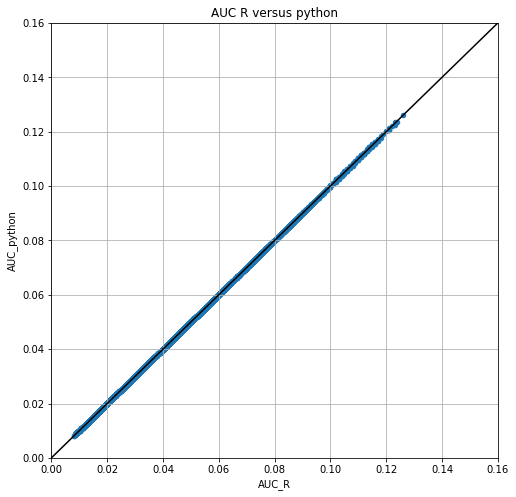

In [104]:
fig, ax = plt.subplots(figsize=(8,8))
c_df.plot.scatter(x='AUC_R', y='AUC_python', grid=True, ax=ax)
plt.xlim([0, 0.16])
plt.ylim([0, 0.16])
import matplotlib.pyplot as plt
plt.plot([0, 0.16], [0, 0.16], 'k-')
plt.title('AUC R versus python')

Text(0.5,1,'AUC$_R$/AUC$_{python}$')

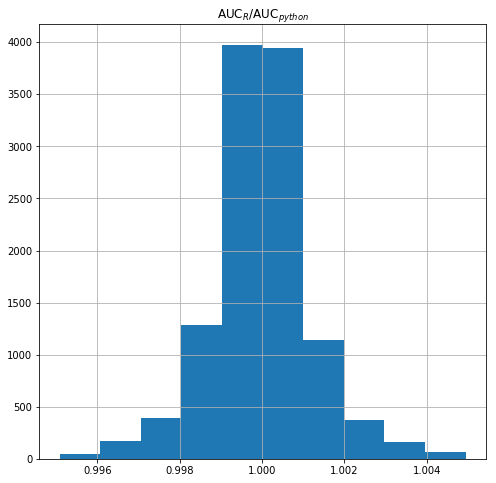

In [105]:
fig, ax = plt.subplots(figsize=(8,8))
(c_df['AUC_R']/c_df['AUC_python']).hist()
plt.title('AUC$_R$/AUC$_{python}$')

In [106]:
(c_df['AUC_R']/c_df['AUC_python']).describe()

count    11558.000000
mean         0.999998
std          0.001224
min          0.995089
25%          0.999365
50%          0.999994
75%          1.000633
max          1.004945
dtype: float64

In [110]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

from functools import partial
c_df['AUC_python_rounded'] = list(map(partial(round_sig, sig=3), c_df['AUC_python']))

In [111]:
c_df[abs(c_df['AUC_R']-c_df['AUC_python_rounded']) > 0.000000001]

,DbId,ModuleType,MotifID,TF,AUC_R,NES_R,AUC_python,NES_python,AUC_python_rounded


Comparison of NES values in a scatter plot.

Text(0.5,1,'NES R versus python')

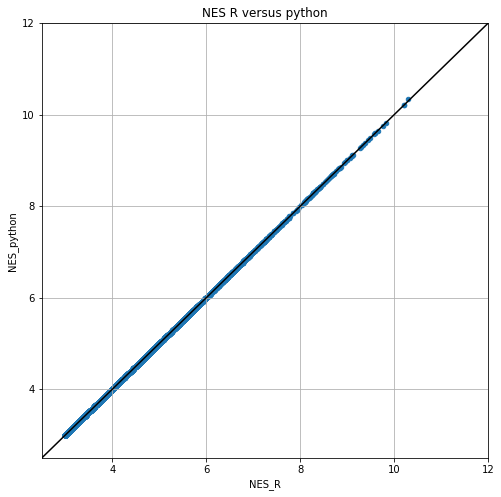

In [112]:
fig, ax = plt.subplots(figsize=(8,8))
c_df.plot.scatter(x='NES_R', y='NES_python', ax=ax, grid=True)
plt.xlim([2.5, 12])
plt.ylim([2.5, 12])
plt.plot([2.5, 12], [2.5, 12], 'k-')
plt.title('NES R versus python')

__Conclusion:__ AUC differences are minimal and can be explained by the rounding to two digits that is being done in the R version of the pipeline.

### Comparison of number of regulomes

Create regulomes for python pipeline.

In [113]:
from pyscenic.algo import df2regulomes

In [114]:
py_df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
                 index_col=[0,1], header=[0,1], skipinitialspace=True)

In [115]:
py_df[('Enrichment', 'TargetGenes')] = list(map(eval, py_df[('Enrichment', 'TargetGenes')]))

In [116]:
regulomes = df2regulomes(py_df, "MGI")

In [117]:
len(regulomes)

391

In [118]:
py_name2targets = {r.transcription_factor: set(r.genes) for r in regulomes}

In [119]:
len(py_name2targets)

391

Create regulomes for R pipeline.

In [120]:
r_incidences = pd.read_csv(os.path.join(RESOURCES_FOLDER, "rscenic/2.6_regulons_asIncidMat.txt"), index_col=0)

In [121]:
r_incidences.shape

(554, 11336)

In [122]:
from matplotlib_venn import venn2

In [123]:
r_extended = set(map(lambda n: n.split('_')[0], filter(lambda n: n.endswith('_extended'), r_incidences.index)))

In [124]:
r_not_extended = set(filter(lambda n: not n.endswith('_extended'), r_incidences.index))

Text(0.5,1,'Number of regulomes')

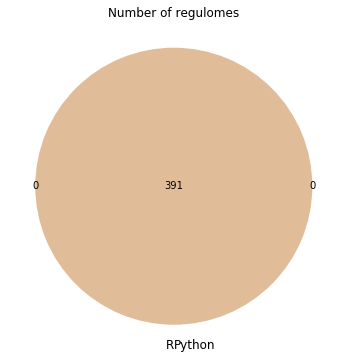

In [125]:
from operator import attrgetter
fig, ax = plt.subplots(figsize=(6,6))
r_names = r_extended.union(r_not_extended)
py_names = set(map(attrgetter('name'), regulomes))
n_intersect = len(r_names.intersection(py_names))
venn2(subsets = (len(r_names)-n_intersect, len(py_names)-n_intersect, n_intersect), set_labels=('R', 'Python'), ax=ax)
plt.title('Number of regulomes')

__Conclusion:__ The difference in number of regulomes can be explained by the fact we do not used the exact same version of motif2tf annotations.

### Comparison of regulomes constituents

In [129]:
r_name2targets = {tf.split('_')[0]:set(row.index[list(map(bool, row.values))].values)
                  for tf, (_, row) in zip(r_incidences.index, r_incidences.iterrows()) if not tf.endswith("_extended")}

R version makes a difference between extended and not extended target genes (from derived motifs). In this notebook the regulomes derived from the dataframe take into account both target genes. We take this into account when comparing.

In [130]:
from cytoolz import merge_with

def union(args):
    if len(args) == 1:
        return args[0]
    return args[0].union(args[1])

tmp_name2targets = {tf.split('_')[0]:set(row.index[list(map(bool, row.values))].values)
                  for tf, (_, row) in zip(r_incidences.index, r_incidences.iterrows()) if tf.endswith("_extended")}
r_name2targets_extended = merge_with(union, r_name2targets, tmp_name2targets)

In [131]:
len(r_name2targets_extended)

391

In [132]:
len(r_name2targets)

318

Compare actual content of the intersecting regulomes via Jaccard Index.

Text(0.5,1,'Distribution of Jaccard Index')

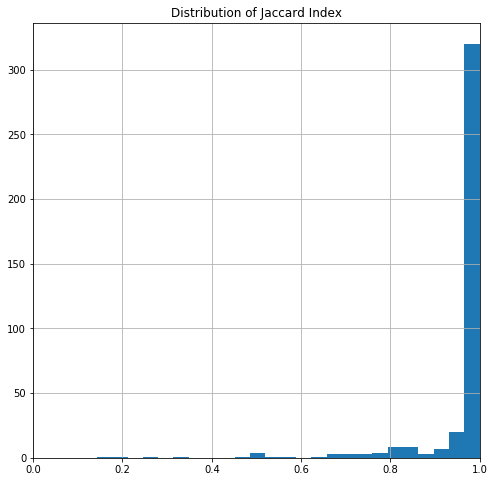

In [133]:
names = set(r_name2targets_extended.keys()).intersection(set(py_name2targets))
n = len(names)
def jaccard(s1, s2):
    return float(len(s1.intersection(s2)))/len(s1.union(s2))
fig, ax = plt.subplots(figsize=(8,8))
ji = pd.DataFrame(data={'JI': list(jaccard(r_name2targets_extended[name], py_name2targets[name]) for name in names)},
                  index=names)
ji.hist(bins=25, ax=ax)
plt.xlim([0, 1.0])
plt.title('Distribution of Jaccard Index')

In [135]:
#py_df.columns = py_df.columns.droplevel(0)
py_df = py_df.reset_index()
DB_MAP = {
    'mm9-500bp-upstream-7species.mc8nr': '500bp',
    'mm9-tss-centered-10kb-7species.mc8nr': '10kbp'
}
def getdb(s):
    for elem in eval(s):
        if elem in DB_MAP:
            return DB_MAP[elem]
    raise ValueError
def getmodule(s):
    for elem in eval(s):
        if elem not in DB_MAP:
            return elem
    raise ValueError
py_df['DbId'] = py_df['Context'].apply(getdb)
py_df['ModuleType'] = py_df['Context'].apply(getmodule)
py_df = py_df[COLUMNS]

In [136]:
c_ji = ji.merge(c_df[['TF', 'NES_python']].groupby(by='TF').mean(), 
         left_index=True, right_index=True).merge(c_df[['TF', 'NES_R']].groupby(by='TF').mean(),
         left_index=True, right_index=True).merge(py_df[['TF', 'MotifID']].groupby(by='TF').count(),
         left_index=True, right_index=True).merge(r_df[['TF', 'MotifID']].groupby(by='TF').count(), suffixes=['_python', '_R'],
         left_index=True, right_index=True).sort_values(by='JI')
c_ji.head(5)

,JI,NES_python,NES_R,MotifID_python,MotifID_R
Mynn,0.142857,3.324769,3.320000,1,1
Grhl1,0.200000,3.458146,3.460000,2,2
Creb3,0.258970,3.659283,3.659268,41,41
Hinfp,0.333333,3.066720,3.070000,1,1
Klf3,0.461538,3.769962,3.769000,10,10


In [140]:
c_ji['motif_diff'] = (c_ji['MotifID_python'] - c_ji['MotifID_R']).abs()

Is there a correlation between JI and NES score?

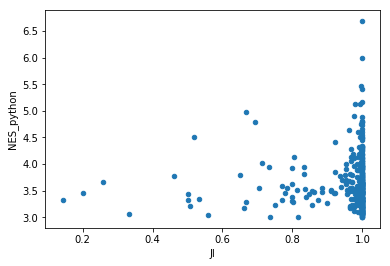

In [137]:
c_ji.plot.scatter(x='JI', y='NES_python')

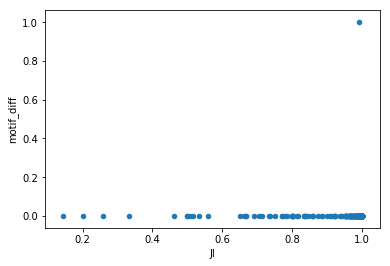

In [150]:
c_ji.plot.scatter(x='JI', y='motif_diff')

In [148]:
py_df[py_df['TF'] == 'Mynn']

,DbId,ModuleType,MotifID,TF,AUC,NES
1728,500bp,top50perTarget,transfac_pro__M05421,Mynn,0.030334,3.324769


In [149]:
r_df[r_df['TF'] == 'Mynn']

,DbId,ModuleType,MotifID,TF,AUC,NES
3000,500bp,top50perTarget,transfac_pro__M05421,Mynn,0.0303,3.32


In [151]:
py_name2targets['Mynn']

{'Adam1a', 'Hsd17b11'}

In [152]:
r_name2targets['Mynn']

{'Adam1a',
 'Ado',
 'Alkbh3',
 'Gins3',
 'Hist1h2bm',
 'Hist1h2bn',
 'Hsd17b11',
 'Mcm4',
 'Myh3',
 'Rab5c',
 'Smarcb1',
 'Trp53i11',
 'Ube2h',
 'Usp49'}

__Conclusion__:
The difference in the actual target genes in the regulomes can be explained by the fact that the R implementation uses an approx method to calculate the avg + 2 std RCC.
Only a few gene signatures are different because of fifferent enriched motids are discovered.

--------

## Phase III: Regulome enrichment

Assess the impact these marginal differences of the consituents of regulomes has on the latest phase in the SCENIC pipeline, i.e. AUCell.

In [169]:
from pyscenic.aucell import create_rankings, enrichment
from pyscenic.genesig import Regulome
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances

In [153]:
ex_mtx = pd.read_csv(os.path.join(RESOURCES_FOLDER, 'GSE60361_C1-3005-Expression.txt'), sep='\t', header=0, index_col=0)
rnk_mtx = create_rankings(ex_mtx)
py_auc_heatmap = pd.concat([enrichment(rnk_mtx.T, regulome) for regulome in regulomes]).unstack('Regulome')
r_regulomes = [Regulome(name, "MGI", targets, name) for name, targets in r_name2targets_extended.items()]
r_auc_heatmap = pd.concat([enrichment(rnk_mtx.T, regulome) for regulome in r_regulomes]).unstack('Regulome')

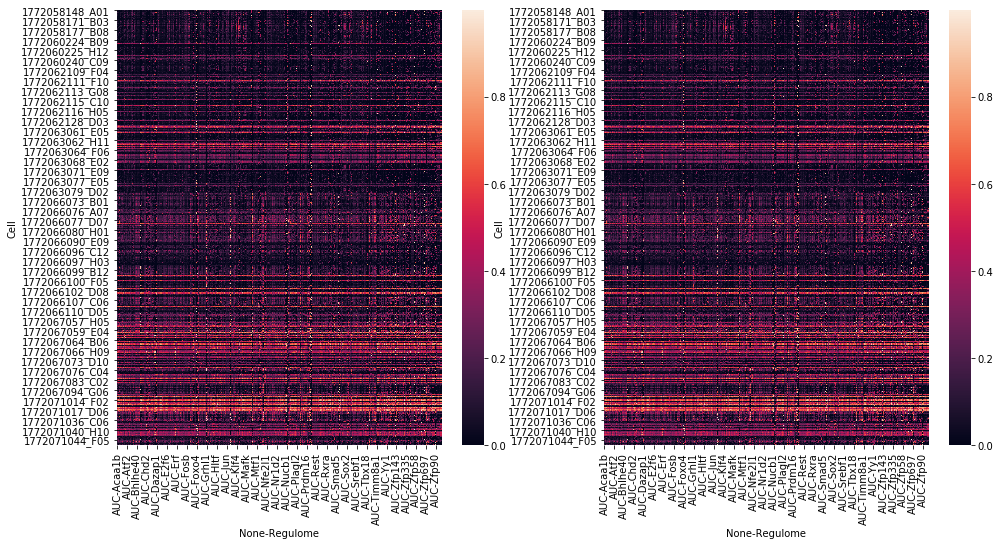

In [174]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
sns.heatmap(py_auc_heatmap, ax=ax1)
sns.heatmap(r_auc_heatmap, ax=ax2)

In [175]:
common_names = py_names.intersection(r_names)
dists = pairwise_distances(r_auc_heatmap.iloc[:,r_auc_heatmap.columns.droplevel(0).isin(common_names)],
                   py_auc_heatmap.iloc[:,py_auc_heatmap.columns.droplevel(0).isin(common_names)], metric='cosine').diagonal()

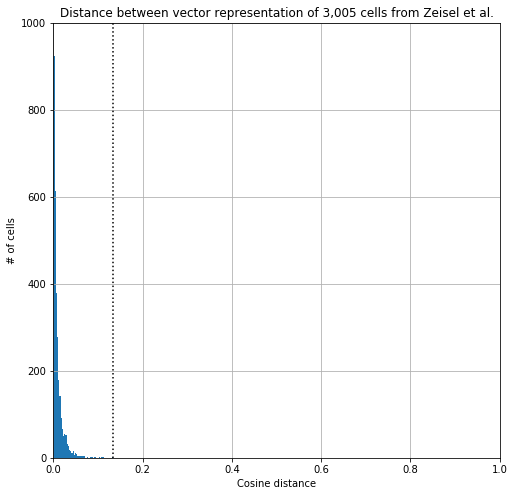

In [176]:
fig, ax = plt.subplots(figsize=(8,8))
pd.DataFrame(data={'dist': dists}, index=ex_mtx.columns).hist(bins=50, ax=ax)
plt.title('Distance between vector representation of 3,005 cells from Zeisel et al.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1000.0])
plt.xlabel('Cosine distance')
plt.ylabel('# of cells')
plt.plot([dists.max(), dists.max()], [0, 1000], 'k:')

__Conclusion:__ The differences are minimal.